### Plotting classification results (supplementary) 

We plot the single and double classification for several featurization parameters.

Data used for plotting can be obtained at https://doi.org/10.5281/zenodo.10812496

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import conntility
import itertools
from scipy import stats
from connalysis.network import local
from loaders import *
import sys 
sys.path.append('../../library')
from structural_basic import load_connectome

# Load and reformat data 

In [2]:
# Get connectivity object neighborhoods
conn_dir="../../data_analysis/data/"
conn="BBP"
connectome=load_connectome(conn_dir, conn)
nbds=local.neighborhood_indices(connectome.matrix, all_nodes=True)

In [3]:
# Directory where the classification files from zeondo TODO: ADD LINK!! have been downloaded
data_dir="/gpfs/bbp.cscs.ch/project/proj9/bisimplices/classification_zenodo" 
# Directory where the structural connectome files from zeondo TODO: ADD LINK!! have been downloaded
full_conn_dir="../../data_analysis/data/"
# TriDy results 
plot_dict=reformat_TriDy_results(data_dir, nbds)
# PCA results 
plot_dict["PCA"]={}
plot_dict["PCA"]["structured"], plot_dict["PCA"]["controls"]=reformat_PCA_results(full_conn_dir, data_dir, nbds)


/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/classification/visualization/loaders.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["selection_order"][temp]="bottom"
/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/classification/visualization/loaders.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["selection_order"][temp]="top"


# Plotting

In [5]:
def plot_change_vs_single(ax, df, acc_label, colors, label, marker="o", markersize=5, labelsize=8):
    "Plot change in accuracy vs single selection accuracy"
    base=df[("single",acc_label)]
    y=df[("double",acc_label)]- base
    ax.scatter(base,y, marker=marker, linestyle='',color=colors[label], label=fparams_short2long[label], s=markersize)
    ax.axline((base.min(),0), slope=0, linestyle="dashed", color="gray")
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_xlabel("Single classification accuracy",fontsize=labelsize)
    ax.set_ylabel("Change in classification accuracy",fontsize=labelsize)
    h, l =ax.get_legend_handles_labels()
    return ax, h, l

def add_shaded_regions(ax, y_bounds_poor, y_bounds_good,
                       x_bounds_poor, x_bounds_redundant, x_bounds_efficient, colors, alpha=0.2):
    # Add shaded regions to distinguish coding regimes                    
    # Poor coding 
    x=x_bounds_poor
    y1=y_bounds_poor[0]*np.ones_like(x)
    y2=y_bounds_poor[1]*np.ones_like(x)
    ax.fill_between(x, y1=y1, y2=y2, alpha=alpha, color=colors["poor_code"], label="poor")

    # Efficient coding 
    x=x_bounds_efficient
    y1=y_bounds_good[0]*np.ones_like(x)
    y2=y_bounds_good[1]*np.ones_like(x)
    ax.fill_between(x, y1=y1, y2=y2, alpha=alpha, color=colors["efficient_code"], label="efficient")

    # Redundant coding 
    x=x_bounds_redundant
    y1=y_bounds_good[0]*np.ones_like(x)
    y2=y_bounds_good[1]*np.ones_like(x)
    ax.fill_between(x, y1=y1, y2=y2, alpha=alpha, color=colors["redundant_code"], label="redundant")
    return ax

def plot_size_vs_acc(ax, df_struct, acc_label, size_label,err_label, 
                     colors, linestyle='', capsize=3, elinewidth=None,
                     labelsize=8, add_legend=True,
                     plot_controls=False, df_random=None,markersize=None,
                     add_shadded_region=True, # parameters of shaded regions
                     largest_efficient=7500, smallest_redundant=15000,
                    min_acc=0.6, max_acc=0.95, min_good_acc=0.8, max_poor_acc=0.7, alpha_regions=0.2):
    # Plot single and double classification 
    for s_type in ["single", "double"]:
        ax.errorbar(df_struct[(s_type, size_label)], df_struct[(s_type, acc_label)],  yerr=df_struct[(s_type, err_label)],
                    linestyle=linestyle, capsize=capsize, elinewidth=elinewidth, label=s_type, color=colors[s_type])
    if add_shadded_region:
        sizes=df_struct[[("single",size_label),("double",size_label)]]
        x_bounds_poor=np.min(sizes), np.max(sizes)
        x_bounds_efficient=np.array([x_bounds_poor[0], largest_efficient])
        x_bounds_redundant=np.array([smallest_redundant, x_bounds_poor[1]])
        y_bounds_poor=[min_acc, max_poor_acc]
        y_bounds_good=[min_good_acc, max_acc]
        ax=add_shaded_regions(ax, y_bounds_poor, y_bounds_good,
                       x_bounds_poor, x_bounds_redundant, x_bounds_efficient, colors, alpha=alpha_regions) 

    if plot_controls: #This only works for PCA at the moment, because I don't know the controls structure of TriDY
        for control_type in ["random_dense", "random_sparse", "random"]:
            df=df_random.xs(control_type, level=0)
            zorder=-1 if control_type=="random" else None # Otherwise random points block visualization
            ax.errorbar(df[size_label], df[acc_label],  yerr=df[err_label],
                        linestyle=linestyle, capsize=capsize,elinewidth=elinewidth, marker="*", 
                        markersize=markersize,label=control_type, color=colors[control_type],zorder=zorder) 
    ax.set_xlabel("Size of union",fontsize=labelsize)
    ax.set_ylabel("Accuracy",fontsize=labelsize)
    ax.spines[["top", "right"]].set_visible(False)
    if add_legend: ax.legend(frameon=False)
    h, l =ax.get_legend_handles_labels()
    return ax, h, l


In [6]:
# Figure settings and color schemes 
titlesize=8
labelsize=6
ticksize=6
conversion=2.54
marker_size=2
linewidth=1

# For labelling plots, long format of the feature parameters 
# Dict tranforming the labels used for saving the data (keys) to the labels used in the plots (values)
fparams_short2long = {
    'PCA': 'PCA',
    'asg':'asg', 'asl':'asl', 'asr':'asr',
    'blsg':'blsg', 'blsl':'blsl', 'blsr':'blsr',
    'blsgR':'blsRg', 'blsRr':'blsRr', 'blsRl':'blsRl',
    'clsg':'clsg', 'clsh':'clsh', 'clsr':'clsr',
    'tpsg':'tpsg', 'tpsl':'tpsl', 'tpsr':'tpsr',
    'tpsgR':'tpsRg', 'tpsRr':'tpsRr', 'tpsRl':'tpsRl',
    'dc2':'dc2', 'dc3':'dc3', 'dc4':'dc4', 'dc5':'dc5', 'dc6':'dc6',
    'nbc':'nbc', 'ec':'ec', 'fcc':'fcc', 'tcc':'tcc',
    'ts':'ns', 'deg':'deg', 'ideg':'ideg','odeg':'odeg'}

# Setting up colors 
colors={
    "single": plt.cm.Set3(2), 
    "double": plt.cm.Set3(0),
    "random": "khaki",#plt.cm.Dark2(1),
    "random_dense": "tab:purple",
    "random_sparse": "tab:cyan",
    "poor_code":"C7",
    "redundant_code":"blue", 
    "efficient_code":"red"}
for i, feature in enumerate(fparams_short2long.keys()): # to get any color for all features for general plot
    colors[feature]=f"C{i%10}"
# Hand chosen parameters for selected features 
selected_features=["PCA", "ts", "ec", "blsr"]

# Hand chosen colors for selected features
for i, feature in enumerate(selected_features):
    colors[feature]=plt.cm.Set2(i)

# For better labels
feature_titles={'PCA':'PCA', 
                'ts':'Activity', 
                'ec':'Topology', 
                'blsr':'Spectral'}
# Bounds for coding regime 
acc_lims={
    "PCA":(0.65,0.9),
    "ts":(0.3,0.9), 
    "ec":(0.25,0.9), 
    "blsr":(0.25,0.72)
}
acc_bounds={}
for feature in selected_features:
    length=acc_lims[feature][1]-acc_lims[feature][0]
    acc_bounds[feature]=(acc_lims[feature][1]-length/4,
                         acc_lims[feature][0]+length/3)

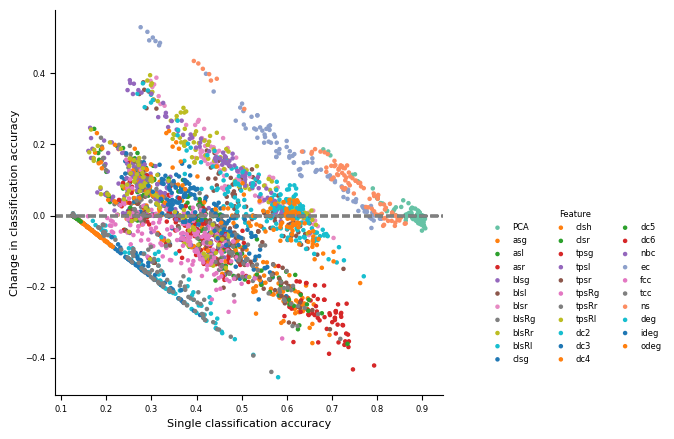

In [7]:
fig, axs = plt.subplots(figsize=(5,5))

# Change in classification 
for feature in list(fparams_short2long.keys()):
    acc_label = "acc" if feature=="PCA" else "cv_acc"
    plot_me=plot_dict[feature]["structured"]
    axs, h, l = plot_change_vs_single(axs, plot_me,acc_label, colors, feature, marker="o", markersize=5)
axs.legend(h,l, frameon=False,fontsize=labelsize, ncols=3, bbox_to_anchor=(1.1,0.5), title="Feature", title_fontsize=labelsize)
axs.tick_params(axis="both", labelsize=6)

#fig.savefig(f"figs/all_features_change_vs_single_acc.png", transparent=True, bbox_inches="tight")

In [8]:
def get_stats_non_zero(df): # To get stats reported on the manuscript 
    temp=plot_me.T.xs("double", level=0).T
    temp=temp["nonzero_count"]*100/temp["total_count"]
    return (temp.mean(), temp.sem(),temp.max())

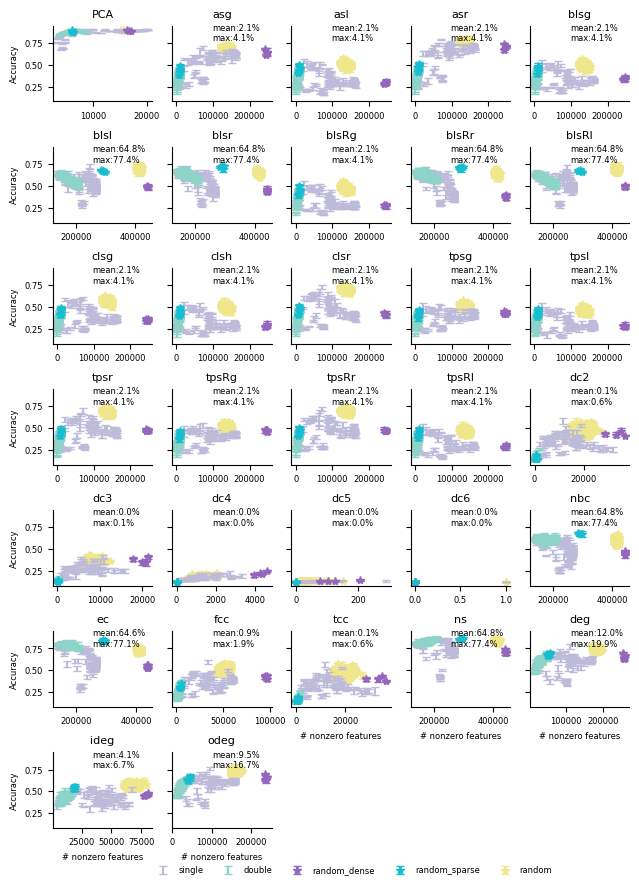

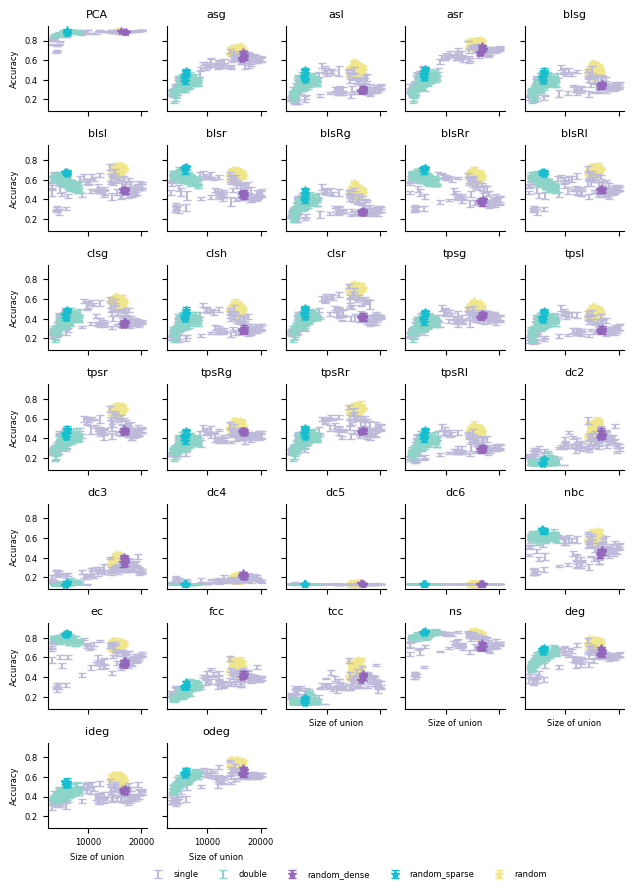

In [9]:
# For relabelling the axes 
x_labels={"nonzero_count": "# nonzero features",
          "size_of_union": "Size of union"}

width=21*0.9/conversion
non_zero_stats={}
for tridy_size in ["nonzero_count", "size_of_union"]:
#for tridy_size in ["nonzero_count"]:
    rows=7; cols=5
    sharex=True if tridy_size=="size_of_union" else False
    fig, axs = plt.subplots(rows, cols, figsize=(width, width*rows/cols), sharey=True, sharex=sharex)
    selected_features=list(fparams_short2long.keys())
    for k, feature in enumerate(selected_features):
        i=k//cols; j=k%cols
        # Single and double classification 
        plot_me=plot_dict[feature]["structured"]
        acc_label, size_label, err_label = ("acc", "size", "sem") if feature =="PCA" else  ("cv_acc", tridy_size, "cv_err")
        # Controls 
        plot_me_random=plot_dict[feature]["controls"] # I currently only have controls for the PCA method
        plot_controls=True
        
        axs[i,j], h, l =plot_size_vs_acc(axs[i,j], plot_me, acc_label, size_label,err_label, 
                                   colors, linestyle='', capsize=3,labelsize=labelsize, add_legend=False, 
                                   plot_controls=plot_controls, df_random=plot_me_random,
                                   add_shadded_region=False)
        axs[i,j].set_xlabel("")
        axs[i,j].set_ylabel("")
        axs[i,0].set_ylabel("Accuracy", fontsize=labelsize)
        axs[i,j].set_title(f"{fparams_short2long[feature]}", fontsize=titlesize)
        if feature =="PCA": #The one that has all labels at the moment 
            axs[-1,cols//2+1].legend(h,l, ncols=5, frameon=False,fontsize=labelsize,
                            bbox_to_anchor=(1.5,-0.4))
        elif tridy_size=="nonzero_count": # Add non-zero counts
            av, sem, ma = get_stats_non_zero(plot_me)
            text=fr"mean:{av:.1f}$\pm$ {sem:.1f}%"+ f"\nmax:{ma:.1f}%"
            text=f"mean:{av:.1f}%\nmax:{ma:.1f}%"
            axs[i,j].annotate(text, xy=(0.4, 0.8), xycoords='axes fraction', fontsize=ticksize)
            non_zero_stats[feature]=(av, sem, ma )

    for ax in np.concatenate([axs[-1,:2], axs[-2,-3:]]):
        ax.set_xlabel(x_labels[size_label], fontsize=labelsize)

    for ax in axs.flatten(): 
        ax.tick_params(axis="both", labelsize=ticksize)

    for ax in axs[-1,-3:]:
        ax.axis("off")
        
    if tridy_size =="nonzero_count":
        plt.subplots_adjust(hspace=0.6)
    else: 
        plt.subplots_adjust(hspace=0.4)

    fig.savefig(f"figs/supp_all_features_acc_vs_{tridy_size}.svg", transparent=True, bbox_inches="tight")
    fig.savefig(f"figs/supp_all_features_acc_vs_{tridy_size}.png", transparent=True, bbox_inches="tight")
non_zero_stats=pd.DataFrame.from_dict(non_zero_stats, orient="index", columns=["mean","sem", "max"])  

In [10]:
display(non_zero_stats)

,mean,sem,max
asg,2.060753,0.097241,4.076752
asl,2.067877,0.097353,4.086392
asr,2.067877,0.097353,4.086392
blsg,2.067877,0.097353,4.086392
blsl,64.755355,0.795844,77.395254
blsr,64.755355,0.795844,77.395254
blsgR,2.067877,0.097353,4.086392
blsRr,64.755355,0.795844,77.395254
blsRl,64.755355,0.795844,77.395254
clsg,2.067877,0.097353,4.086392
